In [29]:

import scipy as sp
import main
import KTCScoring
import numpy as np
import KTCMeshing
import KTCFwd
import glob
import KTCPlotting
import matplotlib.pyplot as plt
from scipy.interpolate import interpn
from scipy.optimize import minimize
from scipy.optimize import Bounds
from scipy.optimize import SR1
from scipy.optimize import least_squares
import func
import statsmodels.api as sm
from scipy.stats import cauchy
from scipy.stats import norm
from scipy.stats import gennorm
from scipy.stats import t
from scipy.stats import laplace
from scipy.stats import uniform

inputFolder = 'TrainingData'
outputFolder = 'Output'
categoryNbr = 1
Nel = 32
Con_Imp = 1e-6
data_number = 3

In [30]:
# Define the meshes
mat_dict = sp.io.loadmat(inputFolder + '/ref.mat') #load the reference data
mat_files = glob.glob(inputFolder + '/data*.mat') # load the real data
mat_dict2 = sp.io.loadmat(mat_files[data_number-1])
Injref = mat_dict["Injref"] #current injections
Uelref = mat_dict["Uelref"] #measured voltages from water chamber
Inj = mat_dict2["Inj"]
Uel = mat_dict2["Uel"]

Mpat = mat_dict2["Mpat"]
Mpat = mat_dict["Mpat"] #voltage measurement pattern
z = Con_Imp * np.ones((Nel, 1))  # contact impedances
Mesh, Mesh2, vincl = func.SetupMesh(categoryNbr, Nel, inputFolder)

In [31]:
# Find the true sigma0 classes on the mesh, and set values according to class
solver = KTCFwd.EITFEM(Mesh2, Injref, Mpat, vincl)
truth = sp.io.loadmat('GroundTruths/true' + str(data_number) + '.mat')
truth = truth["truth"]

# Find pixel centers
pixwidth = 0.23 / 256
pixcenter_x = np.linspace(-0.115 + pixwidth / 2, 0.115 - pixwidth / 2 + pixwidth, 256)
pixcenter_y = pixcenter_x

x, y = np.meshgrid(pixcenter_x, pixcenter_y)
sigma0 = interpn((pixcenter_x,pixcenter_y), truth*1.0, Mesh.g, method='nearest',bounds_error=False,fill_value=0.0)


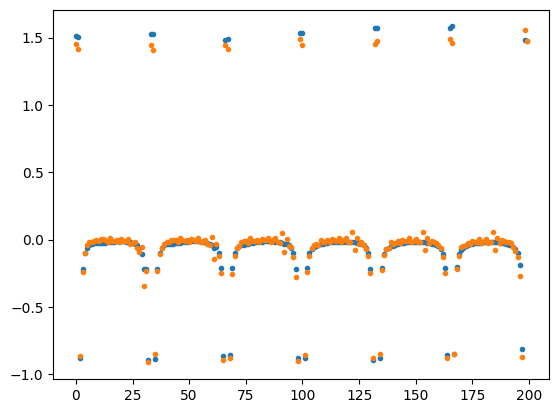

In [49]:

Path = 'Groundtruths/true3.mat'
Uel_Meas = func.ForwardFromPhanton(Path, Mesh, Mesh2,Injref, Mpat, vincl,(0.8,0.030,0.030))
Uelref_Meas = func.ForwardFromPhanton(Path, Mesh, Mesh2,Injref, Mpat, vincl,(0.8,0.8,0.8))

data1 = sp.io.loadmat('TrainingData/data3' + '.mat')
dataref = sp.io.loadmat('TrainingData/ref' + '.mat')

Uel = data1['Uel']
Uelref = dataref['Uelref']


#plt.plot(Uelref[0:100])
#plt.plot((Uelref_Meas[0:200]-Uelref[0:200])/(Uelref[0:200]), linestyle='', marker='.')
#print(np.sum(Uelref))
plt.plot(Uel_Meas[0:200]-Uelref_Meas[0:200]*0, linestyle='', marker='.')
plt.plot(Uel[0:200]-Uelref[0:200]*0, linestyle='', marker='.')


#plt.plot(Uelref[0:100]-Uel[0:100])
#plt.plot(Uelref_Meas[0:100] - Uel_Meas[0:100])





## Minimiize the L2 error over the difference btweeen reference measured and generalet data....

# Functions are defined below

In [61]:
def forward_error(s0, datanumber,norm):

    #s0 = 0.8
    s1 = 1.2
    # Forward map the phantom
    Path = 'Groundtruths/true' + str(datanumber) +'.mat'
    Uel_Meas = func.ForwardFromPhanton(Path, Mesh, Mesh2,Injref, Mpat, vincl,(s0,s1,s1))
    Uelref_Meas = func.ForwardFromPhanton(Path, Mesh, Mesh2,Injref, Mpat, vincl,(s0,s0,s0))
    diff_Meas = Uel_Meas*0 - Uelref_Meas

    # Get true data
    data1 = sp.io.loadmat('TrainingData/data' + str(datanumber) + '.mat')
    dataref = sp.io.loadmat('TrainingData/ref' + '.mat')
    Uel = data1['Uel']
    Uelref = dataref['Uelref']
    diff = Uel*0 - Uelref
    
    # Return the norm difference
    return np.linalg.norm((diff_Meas[0:30] - diff[0:30]).ravel(),norm)

In [47]:
x0 = (10)
res_ref = minimize(forward_error, x0, method='nelder-mead',args =(3,2),options={'xatol': 1e-2,'fatol':1e-2, 'disp': True})
res_ref.x

KeyboardInterrupt: 

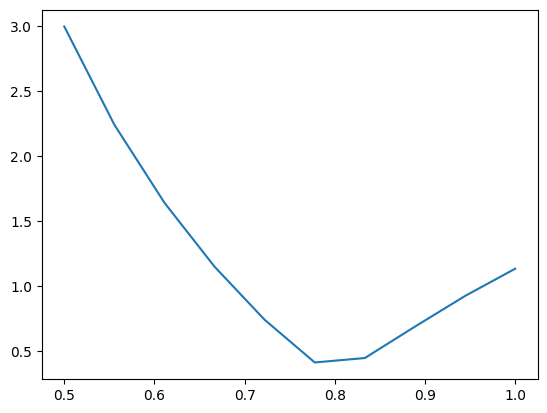

In [62]:
s1 = np.linspace(0.5,1,10)
data = [forward_error(s,3,1) for s in s1]
plt.plot(s1,data)

In [55]:
def forward_error3d(sigmavalues, datanumber,norm):

    s0 = sigmavalues[0]
    s1 = sigmavalues[1]
    s2 = sigmavalues[2]
    # Forward map the phantom
    Path = 'Groundtruths/true' + str(datanumber) +'.mat'
    Uel_Meas = func.ForwardFromPhanton(Path, Mesh, Mesh2,Injref, Mpat, vincl,(s0,s1,s2))
    Uelref_Meas = func.ForwardFromPhanton(Path, Mesh, Mesh2,Injref, Mpat, vincl,(s0,s0,s0))
    diff_Meas = Uel_Meas - Uelref_Meas

    # Get true data
    data1 = sp.io.loadmat('TrainingData/data' + str(datanumber) + '.mat')
    dataref = sp.io.loadmat('TrainingData/ref' + '.mat')
    Uel = data1['Uel']
    Uelref = dataref['Uelref']
    diff = Uel - Uelref
    
    # Return the norm difference
    return np.linalg.norm((diff_Meas - diff).ravel(),norm)

def forward_error_ref(sigmavalue,norm):
    # Set values to sigmavalue at all mesh-points
    sigma = np.ones(Mesh.g.shape)*sigmavalue[0]
    # Map to measurement space with forward operator
    solver = KTCFwd.EITFEM(Mesh2, Injref, Mpat, vincl)
    z = sigmavalue[1] * np.ones((Nel, 1))
    Measurement = solver.SolveForward(sigma, z)
    # Load real data and return 2-norm error
    data = sp.io.loadmat('TrainingData/ref.mat')
    data = data['Uelref']
    diff = np.array(data - Measurement)
    return np.linalg.norm(diff.ravel(),norm)

def forward_error_ref2(sigmavalue,norm):
    # Set values to sigmavalue at all mesh-points
    sigma = np.ones(Mesh.g.shape)*sigmavalue
    # Map to measurement space with forward operator
    solver = KTCFwd.EITFEM(Mesh2, Injref, Mpat, vincl)
    Measurement = solver.SolveForward(sigma, z)
    # Load real data and return 2-norm error
    data = sp.io.loadmat('TrainingData/ref.mat')
    data = data['Uelref']
    diff = np.array(data - Measurement)
    return np.linalg.norm(diff.ravel(),norm)

def forward_error2d(sigmavalues, datanumber,norm):
    truth = sp.io.loadmat('GroundTruths/true' + str(datanumber) + '.mat')
    truth = truth["truth"]
    # Find pixel centers
    pixwidth = 0.23 / 256
    pixcenter_x = np.linspace(-0.115 + pixwidth / 2, 0.115 - pixwidth / 2 + pixwidth, 256)
    pixcenter_y = pixcenter_x
    # Intepolate to ground truth values at mesh points (nearest neighbor)
    sigma0 = interpn((pixcenter_x,pixcenter_y), truth*1.0, Mesh.g, method='nearest',bounds_error=False,fill_value=0.0)
    # Change function values to input at different mesh points
    sigma = np.zeros(sigma0.shape)
    sigma[sigma0<=0.5] = 0.8
    sigma[(sigma0<=1.5) * (sigma0>0.5)] = sigmavalues[0]
    sigma[(sigma0<=2.5) * (sigma0>1.5)] = sigmavalues[1]
    # Map to measurement space with forward operator
    solver = KTCFwd.EITFEM(Mesh2, Injref, Mpat, vincl)
    Measurement = solver.SolveForward(sigma, z)
    Measurement = np.array(Measurement)
    # Load real data and return 2-norm error
    data = sp.io.loadmat('TrainingData/data' + str(datanumber) + '.mat')
    data = data['Uel']
    diff = np.array(data - Measurement)
    return np.linalg.norm(diff.ravel(),norm)

19.27899521625778


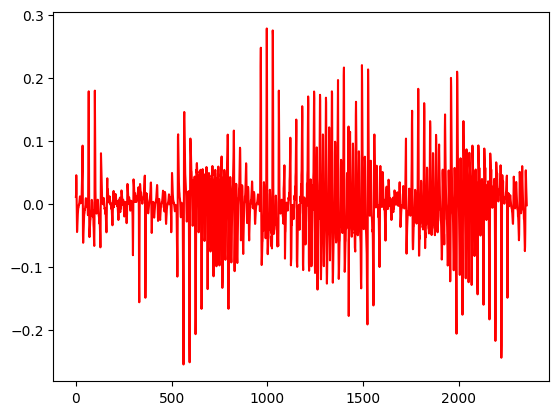

In [53]:
x0 = (0.8,0.002,1000.2)
error = forward_error3d(x0,1,2)
print(error)

In [59]:
x0 = (0.8,0.2,1.2)
res_ref = minimize(forward_error3d, x0, method='nelder-mead',args =(1,2),options={'xatol': 1e-2,'fatol':1e-2, 'disp': True})
res_ref.x

Optimization terminated successfully.
         Current function value: 2.758626
         Iterations: 91
         Function evaluations: 166


array([ 9.90807722, -0.22944668, -0.62899341])

In [38]:
x0 = (0.6,0.2,1.2)
res_ref = minimize(forward_error3d, x0, method='nelder-mead',args =(1,2),options={'xatol': 5*1e-2,'fatol':5*1e-2, 'disp': True})
res_ref.x

c:\Users\marti\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\sparse\_index.py:100: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Optimization terminated successfully.
         Current function value: 2.765188
         Iterations: 2
         Function evaluations: 9


array([0.6, 0.2, 1.2])

In [ ]:
# Conclusion: If the background is set to 0.8, The error function as a function of the two other conductivities is very flat near [0.8,0.8] 
# Data1: starting at [0.1,0.1]: solution=[0.37298192 0.43339776], value=3.3083, norm=2
# Data2: starting at [0.1,0.1]: solution=[0.09393021 0.12941265], value=2.4196, norm=2
# Data3: starting at [0.1,0.1]: solution=[0.     1.8525], value=1.887, norm=2
# Data4: starting at [0.1,0.1]: solution=[0.    0.155], value=2.238, norm=2

# Starting from [1.5,1.5] we get same results for data1 and data2. For data3, we get ([1.36592789 1.85251923], val=1.8869)
# data4: ([0    , 2.325], val = 2.238036)

# Starting from [0.3,1.5]: In order: [0.37283636 0.43297957], [0.11934921 0.        ], [0.27318558 1.85251923], [0.        2.8359375]
# values: 3.308336, 2.441213, 1.886879, 2.238036

# Starting from [1.5,0.3]: In order: [0.37279    0.43289522], [0.         0.15994137]
# values: 3.308336, 2.436770, 1.886879, 2.238036

# Starting from [0.8,0.8] with norm=1: [0.43727557 0.446124  ], [0.11995207 0.1504702 ], [0.42027344 1.67945313], [0.   1.24]

# Starting from [0.8,0.8] with norm=1: [0.154429   0.74875535], [0.         0.09269165], [0.08837891 2.30324219], [0.   1.24]

x0 = np.array([0.8,0.8])
norm = 4
for data in range(4):
    
    bounds = Bounds([0, 0],[10,10])
    res = minimize(forward_error2d, x0, method='nelder-mead',
                  args=(data+1,norm), options={'xatol': 0.9*1e-3,'fatol':0.9*1e-3, 'disp': True}, bounds=bounds)
    print(data)
    print(res.x)

In [ ]:
errorMat = np.zeros((3,3))
s2 = np.array([0.0,0.5,2])
s3 = np.array([0.0,0.5,2])
data_number = 2
for i in range(0,3):
    for j in range(0,3):
        input_cond = np.array([0.802,s2[i],s3[j]])
        errorMat[i,j] = forward_error(input_cond,data_number)

print(errorMat)

In [ ]:
sigma = np.zeros(sigma0.shape)
sigma[sigma0<=0.5] = res.x[0]
sigma[(sigma0<=1.5) * (sigma0>0.5)] = res.x[1]
sigma[(sigma0<=2.5) * (sigma0>1.5)] = res.x[2]
sgplot.basic2Dplot(sigma,[], ['linear difference reconstruction'])

In [ ]:
sigmavalue = 0.8
sigma = np.ones(Mesh.g.shape)*sigmavalue
solver = KTCFwd.EITFEM(Mesh2, Injref, Mpat, vincl)
Measurement = solver.SolveForward(sigma, z)
# Load real data and return 2-norm error
data = sp.io.loadmat('TrainingData/ref.mat')
data = data['Uelref']
diff = np.array(data - Measurement)
print(np.squeeze(diff).shape)
st_diff = (np.squeeze(diff)-np.mean(diff))/np.std(diff)
x_quantiles = np.linspace(0,1,num = len(st_diff),endpoint=False)
quantiles = norm.ppf(x_quantiles)
plt.plot(quantiles, np.sort(st_diff))
plt.plot(quantiles, quantiles)
plt.show()

quantiles = t.ppf(x_quantiles,5)
plt.plot(quantiles, np.sort(st_diff))
plt.plot(quantiles, quantiles)
plt.show()

quantiles = laplace.ppf(x_quantiles)
plt.plot(quantiles, np.sort(st_diff))
plt.plot(quantiles, quantiles)
plt.show()

quantiles = gennorm.ppf(x_quantiles,1.2)
plt.plot(quantiles, np.sort(st_diff))
plt.plot(quantiles, quantiles)
plt.show()


Now we do a reconstruction: